# Dev: My Data Quality


In [1]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
from pandas.api.types import is_object_dtype
from bhatta_dist import max_bhatta_dist
import itertools
import yaml
import logging
# logging by screen
logging.basicConfig(level=logging.INFO)
logging.info("Start ...")


INFO:root:Start ...


### functions

In [2]:
def missing(data:pd.DataFrame):
        """
        Missing values analysis.
        data -- df to be analized.
        return -- None.
        """
        # estimate number of missing values
        ntotal_missing = data.isnull().sum().sum()
        # validate
        if ntotal_missing == 0:
            print('There are not any missing values.')
        else:
            import matplotlib.pyplot as plt
            import missingno as msno
            # missing values graph
            msno.matrix(data)
            plt.show()
            # counting non-missing values
            msno.bar(data)
            plt.show()
            # correlation between missing values
            msno.heatmap(data)
            plt.show()


## remove outliers of a 1D array according to the Inter Quartile Range (IQR)
def mark_outliers_IQR(v:np.array, verbose:bool = False)->np.array:
    """
    Remove outliers of a 1D array according to the Inter Quartile Range (IQR).
    v -- array of values to be analyzed.
    verbose -- display extra information (default, False).
    return -- array of values after removing outliers.
    """
    # map infinite value
    v[v==np.inf] = np.nan
    # estimate boundary thresholds
    Q1 = np.nanquantile(v,0.25)
    Q3 = np.nanquantile(v,0.75)
    IQR = Q3 - Q1
    t_lower = Q1 - 1.5*IQR
    t_upper = Q3 + 1.5*IQR
    # display
    if verbose:
        print('Thresholds: lower = %.5f / upper = %.5f'%(t_lower, t_upper))
    # remove values outside of these thresholds and return
    v[v < t_lower] = np.inf
    v[v > t_upper] = np.inf
    # return
    return v


def describe_outliers(df:pd.DataFrame):
    """
    Outlier values analysis. The outlier detection tecnique used is with IQR distances.
    df -- df to be analyzed.
    return -- None.
    """
    # get names of numeric columns
    cols_num = df.select_dtypes(include=['float64', 'int64']).columns.values
    # validate
    if len(cols_num) == 0:
        # display
        print('There are not any numerical columns in this dataframe.')
        # return
        return None
    # initialize output df
    temp = pd.DataFrame(np.zeros(df[cols_num].shape, dtype = bool), columns = cols_num)
    # loop of columns
    for c in cols_num:
        # collect data
        v = df[c].values
        # mark outliers
        v = mark_outliers_IQR(v, verbose = False)
        # include in marks in output df
        temp[c] = (v == np.inf)
    # number of outliers found
    num_outliers = temp.sum().sum()
    # validate if there are or not outliers
    if num_outliers == 0:
        print("There are not any outlier in numerical columns.")
    else:
        # replace True values with NaN to be detected as a missing value
        temp.replace(True, np.nan, inplace = True)    
        # launch missing analysis
        missing(temp)
    # return
    return None

# expectations

In [3]:
with open('expectations.yaml', 'r') as file:
    expecations = yaml.safe_load(file)



In [4]:
expecations

{'sepal length (cm)': {'type': 'float',
  'mandatory_column': True,
  'range_count_rows': [150, 150],
  'range_values': [0, 10],
  'maximum_percent_null': 0,
  'mandatory_unique_values': False},
 'sepal width (cm)': {'type': 'float',
  'mandatory_column': True,
  'range_count_rows': [150, 150],
  'range_values': [0, 10],
  'maximum_percent_null': 0,
  'mandatory_unique_values': False},
 'petal length (cm)': {'type': 'float',
  'mandatory_column': True,
  'range_count_rows': [150, 150],
  'range_values': [0, 10],
  'maximum_percent_null': 0,
  'mandatory_unique_values': False},
 'petal width (cm)': {'type': 'float',
  'mandatory_column': True,
  'range_count_rows': [150, 150],
  'range_values': [0, 10],
  'maximum_percent_null': 0,
  'mandatory_unique_values': False},
 'target': {'type': 'str',
  'mandatory_column': True,
  'range_count_rows': [150, 150],
  'possible_values': ['setosa', 'versicolor', 'virginica'],
  'maximum_percent_null': 0,
  'mandatory_unique_values': False}}

# dataset

In [5]:
dd = load_iris()
df = pd.DataFrame(dd["data"], columns = dd["feature_names"])
df["target"] = dd["target"]
d_target = dict()
for i, v in enumerate(dd["target_names"]):
    d_target[i] = v
df["target"] = df["target"].map(d_target)
df.shape, df.columns


((150, 5),
 Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
        'petal width (cm)', 'target'],
       dtype='object'))

# Expectations

In [6]:
from datetime import datetime
d_types = {
    "float": float,
    "int": int,
    "str": str,
    "datetime": datetime
}

In [7]:
# initialize warnings table
table_warms = list()
# loop of columns
for column in expecations.keys():
    # validate if the column exits
    is_column_exists = column in df.columns.tolist()
    # collect validations for current column
    validations = expecations[column].keys()
    # loop of validations
    for validation in validations:
        ## column data type
        if validation == "type" and is_column_exists:
            # column type
            column_type = d_types[expecations[column][validation]]
            # validation
            if not column_type is str:
                is_success = df[column].dtype == column_type
            else:
                is_success = is_object_dtype(df[column].dtype)
            if not is_success:
                # display
                logging.warning(f"[{validation}] Column '{column}' is not a {column_type}.")
                # append
                table_warms.append([column, validation, f"Wrong column type: {df[column].dtype} / {column_type}."])
        ## mandatory column
        elif validation == "mandatory_column":
            # is mandatory or not
            is_mandatory = expecations[column][validation]
            # validation
            if is_mandatory:
                is_success = column in df.columns.tolist()
                if not is_success:
                    # display
                    logging.warning(f"[{validation}] Column '{column}' is mandatory but not exits.")
                    # append
                    table_warms.append([column, validation, f"Mandatory column not exits."])
        ## number of records
        elif validation == "range_count_rows" and is_column_exists:
            # count ranges
            range_count_rows = expecations[column][validation]
            # validation
            is_success = (len(df) >= range_count_rows[0]) & (len(df) <= range_count_rows[1])
            if not is_success:
                # display
                logging.warning(f"[{validation}] Column '{column}' has an out of range number or records: {len(df)}.")
                # append
                table_warms.append([column, validation, f"Number of records out of range: {len(df)} / {range_count_rows}."])
        ## range of values
        elif validation == "range_values" and is_column_exists and not is_object_dtype(df[column].dtype):
            # values ranges
            range_values = expecations[column][validation]
            # validation
            is_success = (df[column].min() >= range_values[0]) & (df[column].max() <= range_values[1])
            if not is_success:
                # display
                logging.warning(f"[{validation}] Column '{column}' has some out of range values.")
                # append
                table_warms.append([column, validation, f"Values out of range: min = {df[column].min()}, max = {df[column].max()} / {range_values}."])
        ## percent of nulls
        elif validation == "maximum_percent_null" and is_column_exists:
            # max percent of nulls
            max_per_nulls = expecations[column][validation]
            # real percent of nulls
            per_nulls = df[column].isnull().sum() * 100 / len(df)
            # validation
            is_success = per_nulls <= float(max_per_nulls)
            if not is_success:
                # display
                logging.warning(f"[{validation}] Column '{column}' has a bigger percent of nulls than allowed: {per_nulls} %.")
                # append
                table_warms.append([column, validation, f"Too much null values: {per_nulls} % / {max_per_nulls} %."])
        ## only unique values
        elif validation == "mandatory_unique_values" and is_column_exists:
            # check if it is mandatory
            is_mandatory_unique_values = expecations[column][validation]
            # validation
            if is_mandatory_unique_values:
                is_success = len(df) == len(df[column].unique())
                if not is_success:
                    # display
                    logging.warning(f"[{validation}] Column '{column}' do not have all values uniques despite of it is mandatory.")
                    # append
                    table_warms.append([column, validation, f"It must be an index column."])
        ## possible values for catetorical column
        elif validation == "possible_values" and is_column_exists and is_object_dtype(df[column].dtype):
            # possible values
            possible_values = expecations[column][validation]
            # non possible values
            non_possible_values = [v for v in df[column].unique() if not v in possible_values]
            # validation
            is_success = len(non_possible_values) == 0
            if not is_success:
                # display
                logging.warning(f"[{validation}] Column '{column}' contains non possible values: {non_possible_values}.")
                # append
                table_warms.append([column, validation, f"There are not allowed values: {non_possible_values} / {possible_values}."])
        ## other case
        else:
            logging.error(f"The validation {validation} for the thecolumn '{column}' not exists yet.")
# warnings table to df
dfwarms = pd.DataFrame(table_warms, columns = ["column", "validation", "message"])
# display
logging.info(f"There are {len(dfwarms)} warnings.")

INFO:root:There are 0 warnings.


In [8]:
dfwarms

,column,validation,message


# Drift analysis according to a categorical column

In [9]:
# list of numerical columns
l_columns_num  = df.select_dtypes(include=['float64']).columns.tolist()  
# selected categorical column
s_column_cat = 'target'
# list of possible values of categorical column
l_values_cat = list(df[s_column_cat].unique())
# combinations of categorical column values
l_combinations_values_cat = list(itertools.combinations(l_values_cat,r=2))

In [10]:
table_drift = list()
for col_num in l_columns_num:
    # Maximum Bhattacharyya distance 
    max_dist = max_bhatta_dist(df[col_num].values, df[s_column_cat].values, method='continuous')  
    #print(col_num, max_dist)
    table_drift.append([col_num, max_dist])
dfdrift = pd.DataFrame(table_drift, columns = ["col_num", "max_bhatta_dist"]).sort_values("max_bhatta_dist", ascending = False)
dfdrift

,col_num,max_bhatta_dist
2,petal length (cm),inf
3,petal width (cm),189.006292
0,sepal length (cm),1.766414
1,sepal width (cm),0.714650


In [11]:
table_drift_couple = list()
for col_num in l_columns_num:
    for couple_values_cap in l_combinations_values_cat:
        # Maximum Bhattacharyya distance 
        max_dist = max_bhatta_dist(df[df[s_column_cat].isin(list(couple_values_cap))][col_num].values, df[df[s_column_cat].isin(list(couple_values_cap))][s_column_cat].values, method='continuous')  
        #print(col_num, couple_values_cap, max_dist)
        table_drift_couple.append([col_num] + list(couple_values_cap) + [max_dist])
dfdriftcouple = pd.DataFrame(table_drift_couple, columns = ["col_num", "value_cat_1", "value_cat_2", "max_bhatta_dist"]).sort_values("max_bhatta_dist", ascending = False)
dfdriftcouple


,col_num,value_cat_1,value_cat_2,max_bhatta_dist
7,petal length (cm),setosa,virginica,inf
10,petal width (cm),setosa,virginica,189.006292
6,petal length (cm),setosa,versicolor,124.315299
9,petal width (cm),setosa,versicolor,82.699036
1,sepal length (cm),setosa,virginica,1.766414
11,petal width (cm),versicolor,virginica,1.330409
8,petal length (cm),versicolor,virginica,1.282370
0,sepal length (cm),setosa,versicolor,0.765101
3,sepal width (cm),setosa,versicolor,0.714650
4,sepal width (cm),setosa,virginica,0.426996


![iris eda](https://www.w3resource.com/w3r_images/python-machine-learning-scikit-learn-iris-visualization-exercise-13.png)

# Missing values

In [12]:
missing(df)

There are not any missing values.


# Outliers

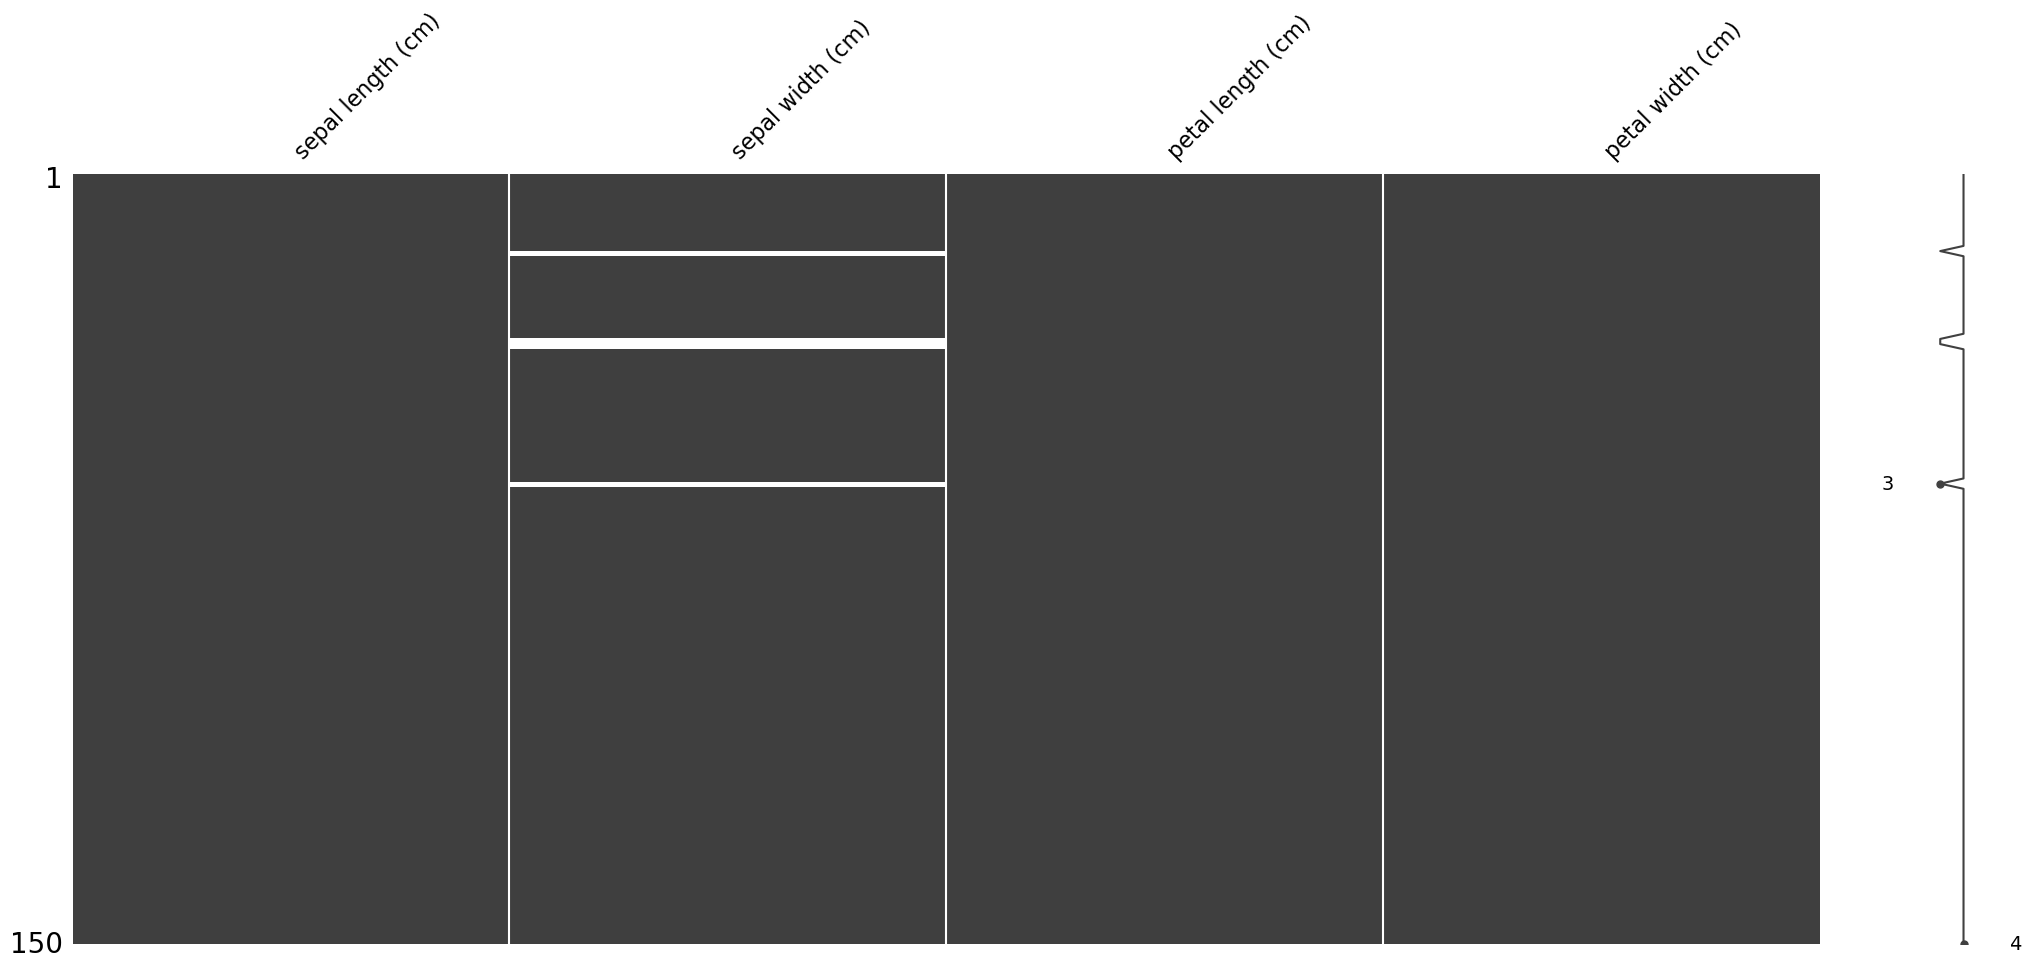

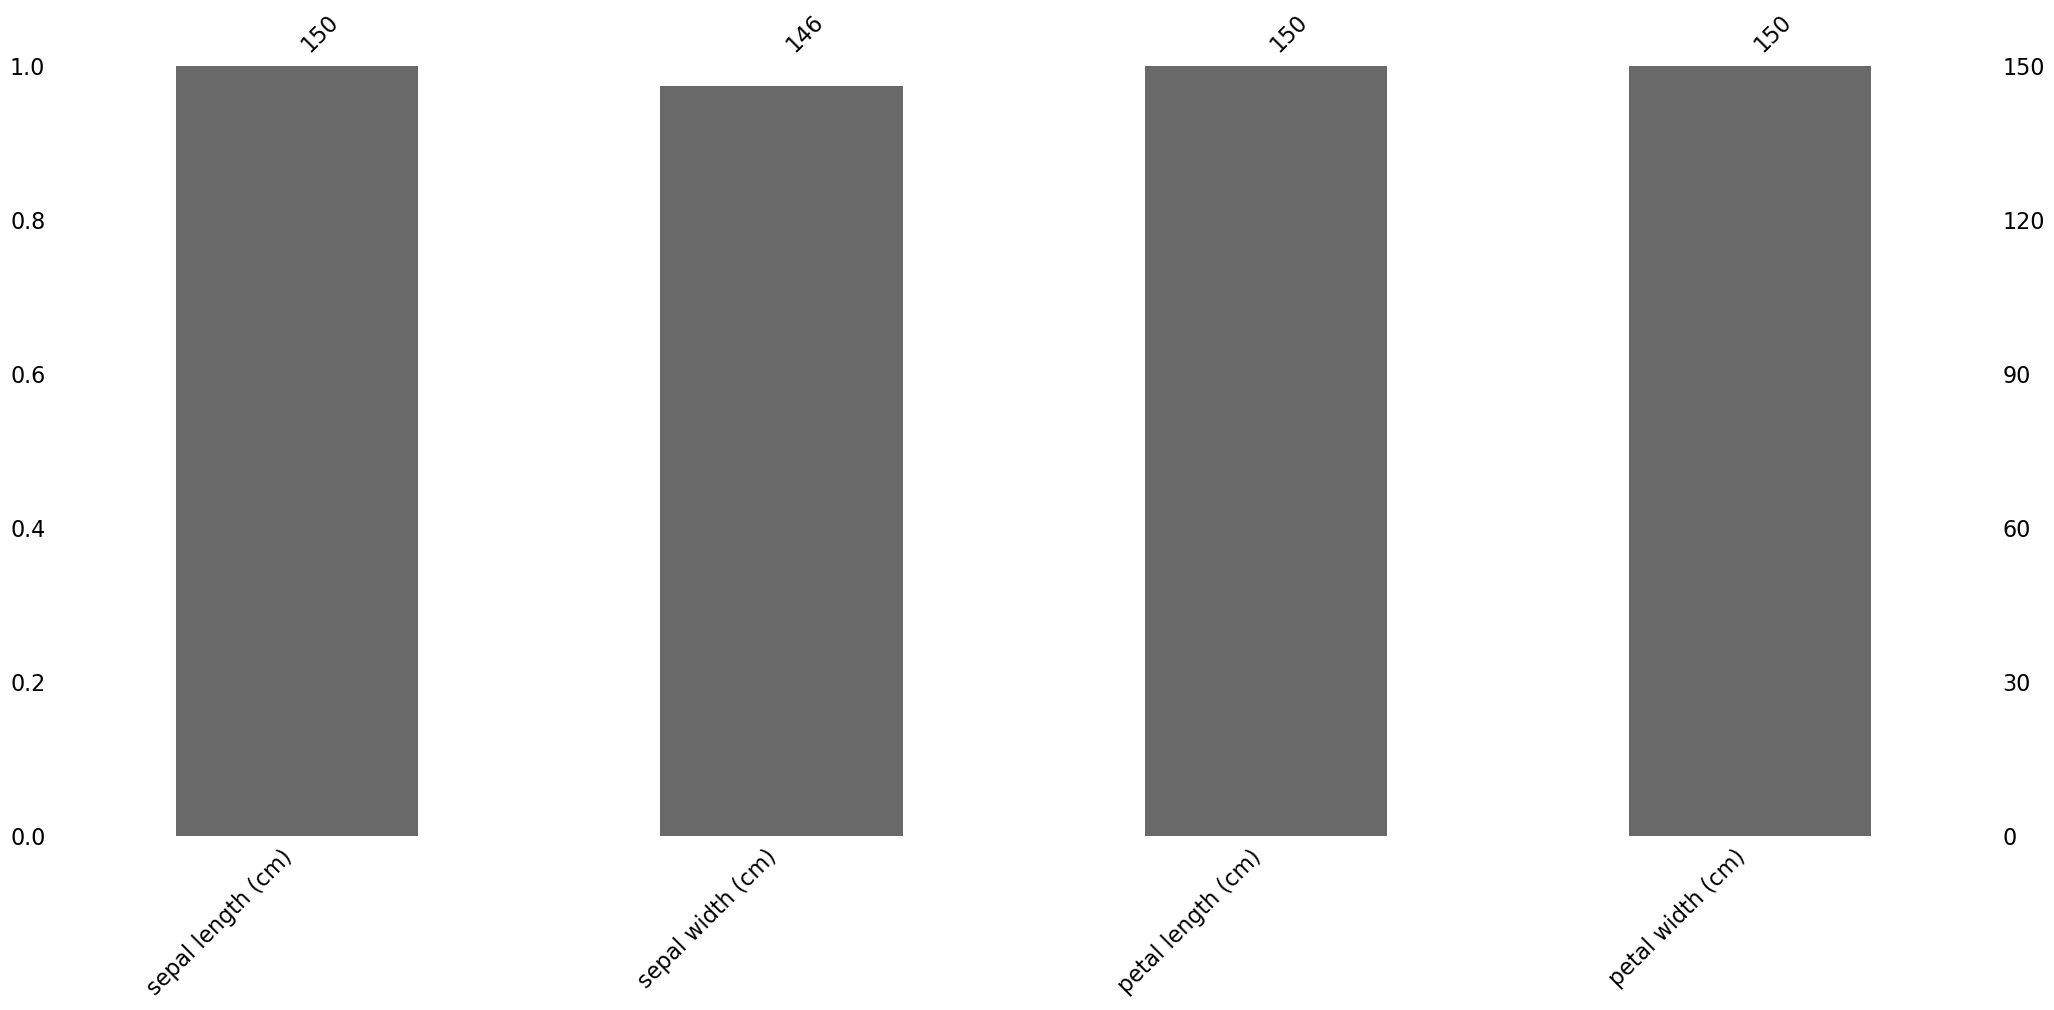

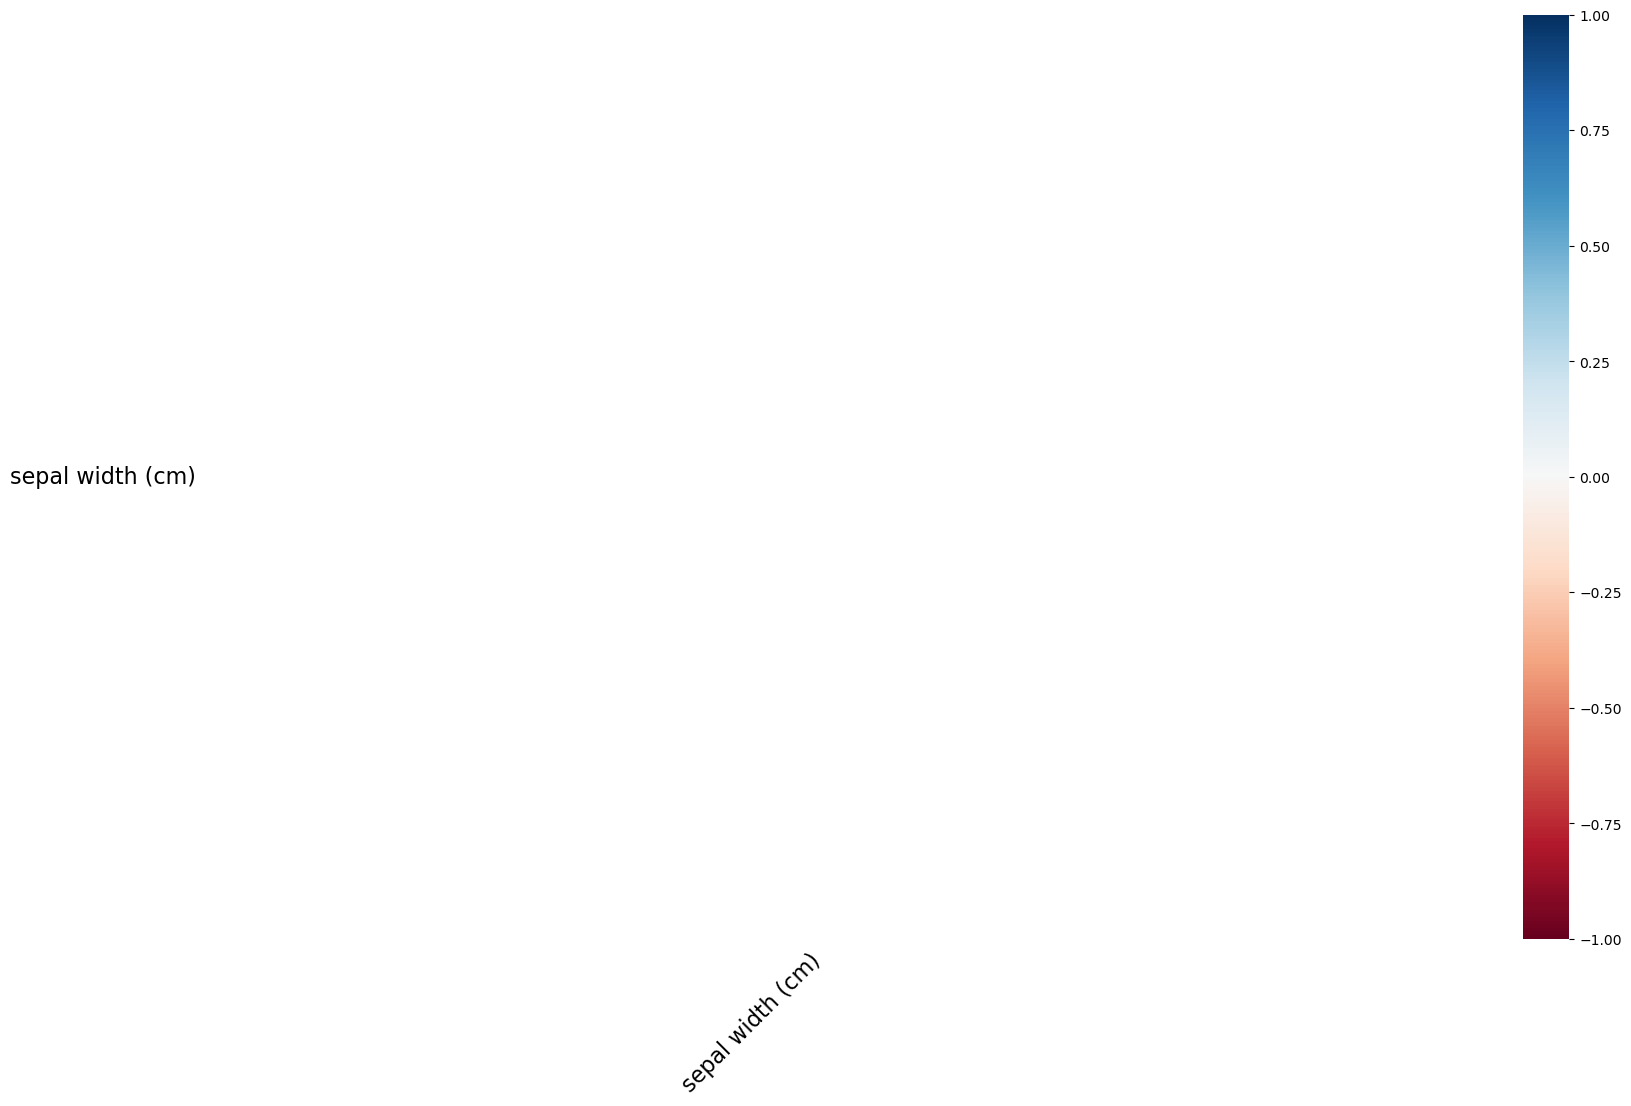

In [13]:
describe_outliers(df)